In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import os

In [5]:
data = pd.read_csv("OnlineRetail.csv", encoding='ISO-8859-1')

print(data.head())
print(data.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

.حالا برای ادامه کار باید دیتامونو تمیز کنیم
حذف ابجکت هایی که ویژگی هایی خالی دارند
و حذف دیتا های مشکوک و منفی

In [6]:
data_clean = data.dropna()

data_clean = data_clean[(data_clean['Quantity'] > 0) & (data_clean['UnitPrice'] > 0)]

#ایجاد ویژگی معنی‌دار برای تحلیل
data_clean['TotalPrice'] = data_clean['Quantity'] * data_clean['UnitPrice']


دیتای جدیدمون

In [7]:
print(data_clean.head())
print(data_clean.describe())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom       15.30  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom       20.34  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom       22.00  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom       20.34  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom       20.34  
            Quantity      UnitPrice     CustomerID     TotalPrice
count  397884.000000  397884.000000  397884.000000  397884.000000
mean     

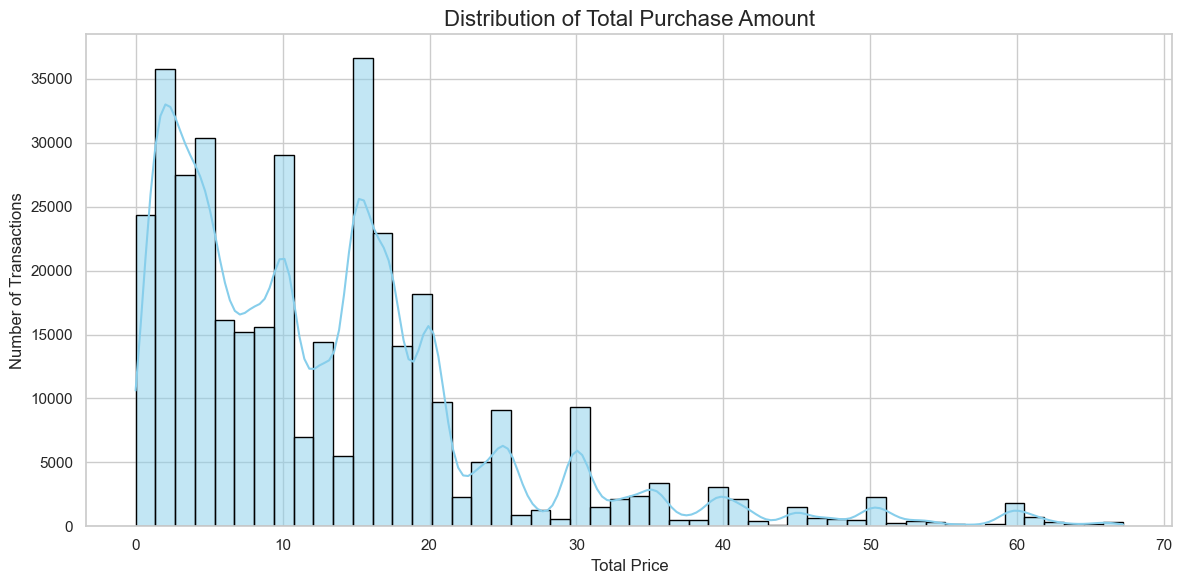

In [8]:
filtered_data = data_clean[data_clean['TotalPrice'] < data_clean['TotalPrice'].quantile(0.95)]

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['TotalPrice'], bins=50, kde=True, color='skyblue', edgecolor='black')

plt.title("Distribution of Total Purchase Amount", fontsize=16)
plt.xlabel("Total Price", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.tight_layout()
plt.show()


هیستوگرام: تعداد نمونه‌ها در هر بازه رو نشون میده

خط : توزیع کلی و نرم داده‌ها رو نمایش میده 

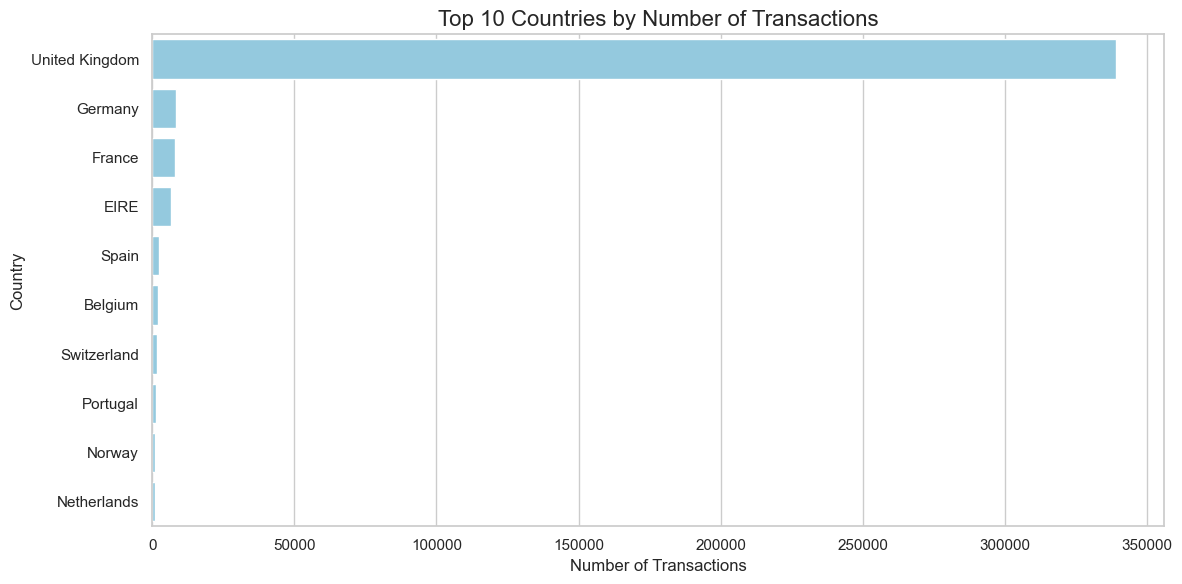

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
country_counts = filtered_data['Country'].value_counts().head(10)
sns.barplot(x=country_counts.values, y=country_counts.index, color='skyblue')
plt.title("Top 10 Countries by Number of Transactions", fontsize=16)
plt.xlabel("Number of Transactions", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25364\3296855287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['InvoiceDate'] = pd.to_datetime(filtered_data['InvoiceDate'])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_25364\3296855287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Month'] = filtered_data['InvoiceDate'].dt.to_period('M')


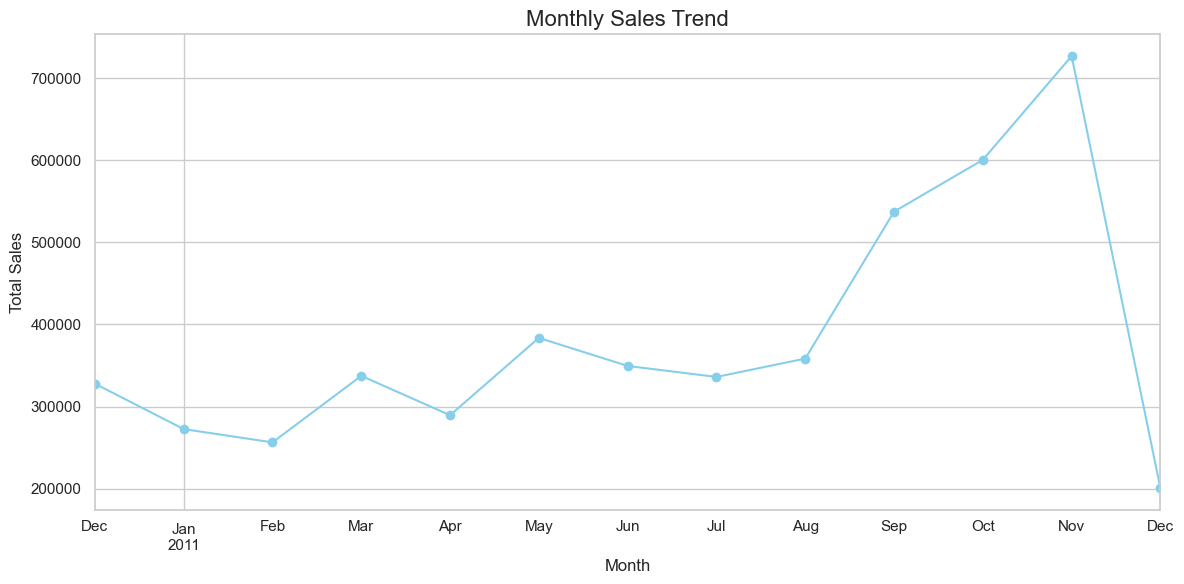

In [10]:
filtered_data['InvoiceDate'] = pd.to_datetime(filtered_data['InvoiceDate'])
filtered_data['Month'] = filtered_data['InvoiceDate'].dt.to_period('M')
monthly_sales = filtered_data.groupby('Month')['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', color='skyblue')
plt.title("Monthly Sales Trend", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25364\965315748.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


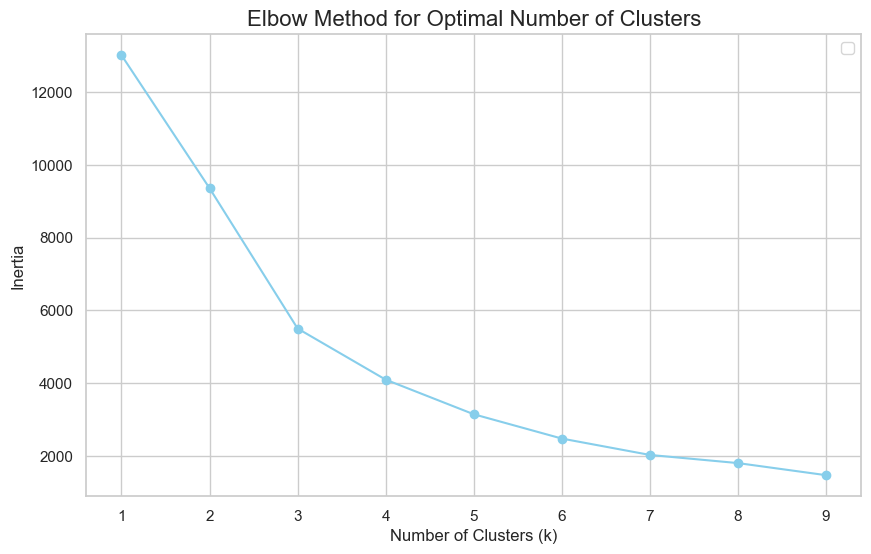

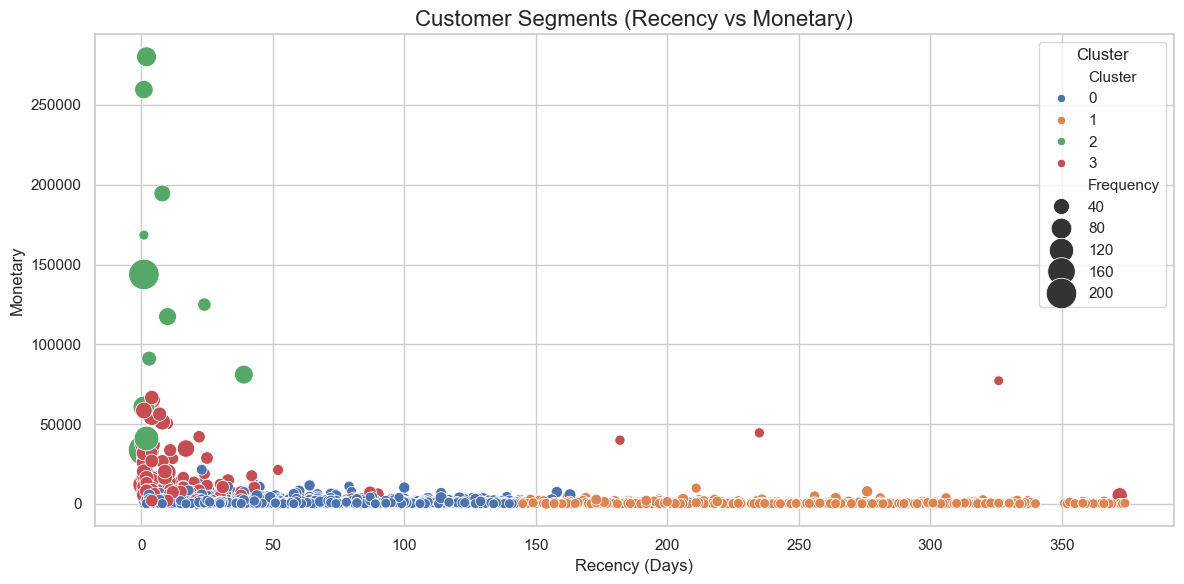

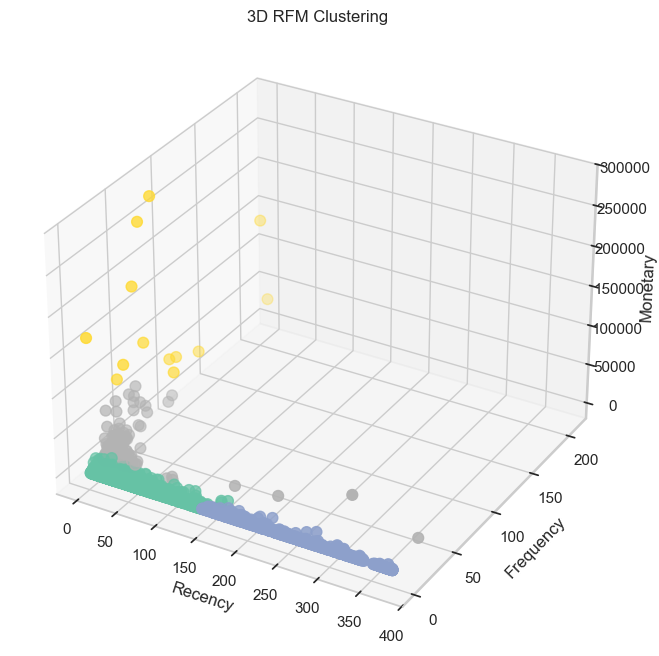

In [11]:

# تبدیل  به فرمت تاریخ
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])

# مرحله 1: محاسبه RFM
# تاریخ مرجع برای Recency
snapshot_date = data_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# گروه‌بندی بر اساس CustomerID برای محاسبه RFM
rfm = data_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# تغییر اسم ستون‌ها
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# مرحله 2: نرمال‌سازی داده‌ها
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# مرحله 3: انتخاب تعداد خوشه‌ها با روش Elbow
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# رسم نمودار Elbow
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, marker='o', color='skyblue')
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16)
plt.legend()
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(True)
plt.show()

# مرحله 4: اجرای K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# مرحله 5: تحلیل خوشه‌ها
# میانگین RFM برای هر خوشه
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()
cluster_summary.columns = ['Cluster', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']

# 💡 افزودن نام به خوشه‌ها
cluster_names = {
    0: 'مشتریان وفادار اقتصادی 🟡',
    1: 'مشتریان VIP 🟢',
    2: 'مشتریان از‌دست‌رفته 🔴',
    3: 'مشتریان غیرفعال ⚪️'
}
rfm['Cluster_Name'] = rfm['Cluster'].map(cluster_names)
cluster_summary['Cluster_Name'] = cluster_summary['Cluster'].map(cluster_names)

# مصورسازی خوشه‌ها 
plt.figure(figsize=(12, 6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette='deep', size=rfm['Frequency'], sizes=(50, 500))
plt.title('Customer Segments (Recency vs Monetary)', fontsize=16)
plt.xlabel('Recency (Days)', fontsize=12)
plt.ylabel('Monetary', fontsize=12)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# ذخیره نتایج RFM و خوشه‌ها
rfm.to_csv('rfm_clusters.csv', index=False)

# مصورسازی 3 بعدی RFM
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], 
           c=rfm['Cluster'], cmap='Set2', s=60)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D RFM Clustering')
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25364\3450887427.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Recency', data=rfm, palette='Set2')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_25364\3450887427.py:7: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
d:\code\python\Classtering with K-mean\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


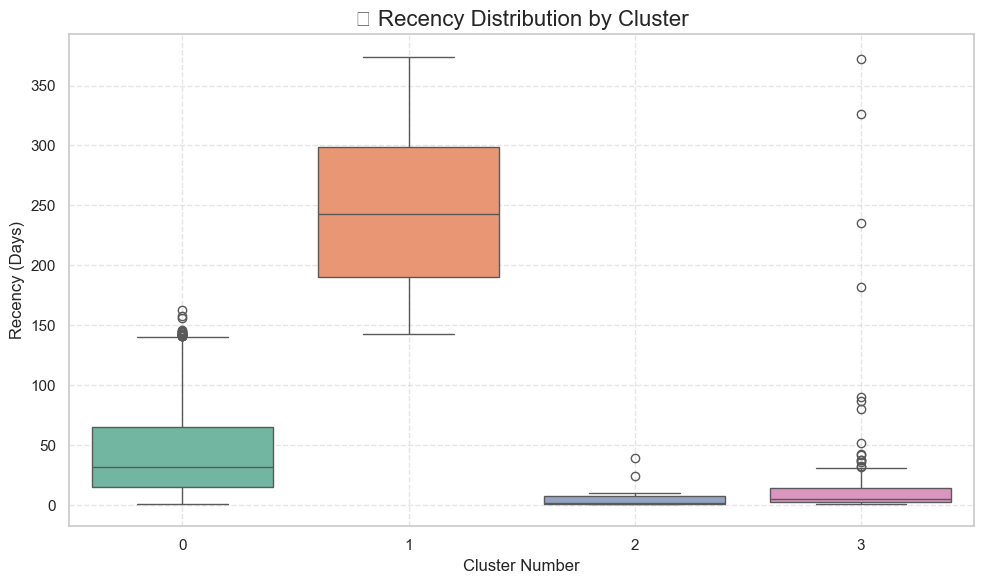

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25364\3450887427.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Frequency', data=rfm, palette='Set3')
d:\code\python\Classtering with K-mean\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


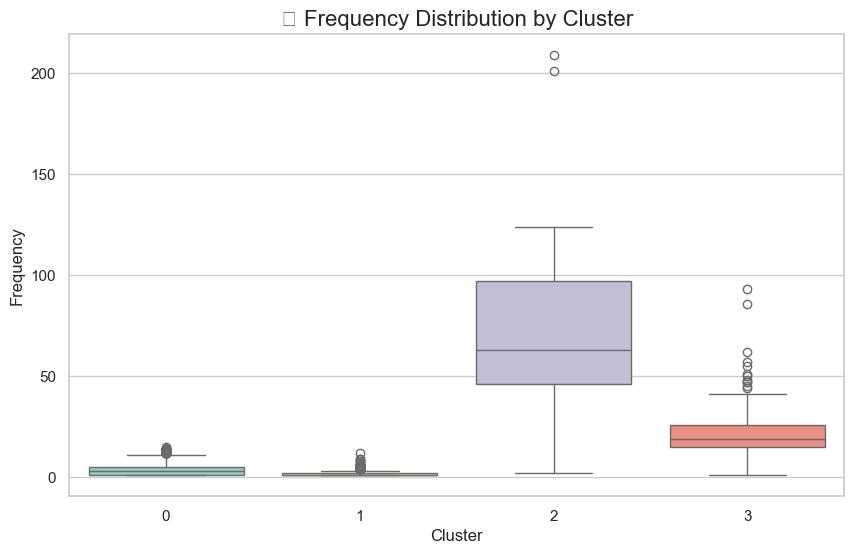

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25364\3450887427.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Monetary', data=rfm, palette='Set1')
d:\code\python\Classtering with K-mean\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


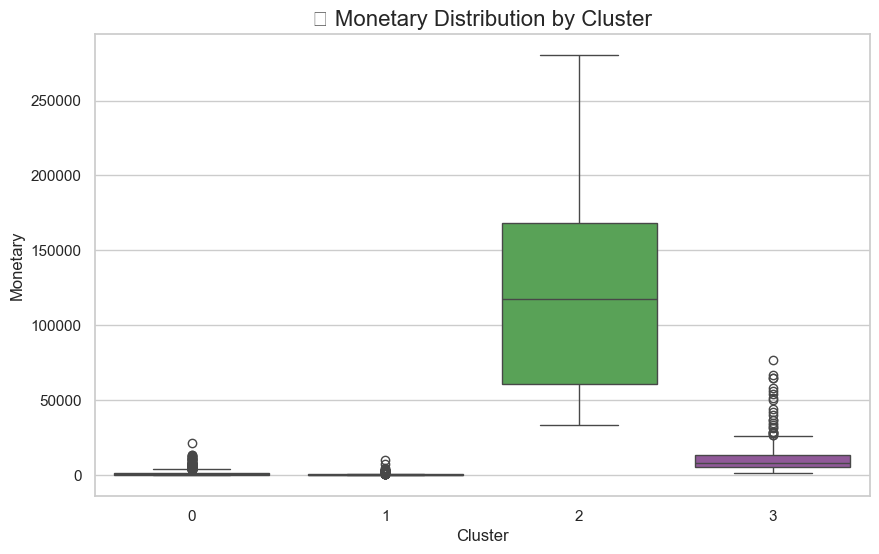

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Recency', data=rfm, palette='Set2')
plt.title('📦 Recency Distribution by Cluster', fontsize=16)
plt.xlabel('Cluster Number', fontsize=12)
plt.ylabel('Recency (Days)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Frequency', data=rfm, palette='Set3')
plt.title('🛒 Frequency Distribution by Cluster', fontsize=16)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Monetary', data=rfm, palette='Set1')
plt.title('💰 Monetary Distribution by Cluster', fontsize=16)
plt.show()


در این مرحله، هدف ما این است که مشتریان هر خوشه را به‌صورت جداگانه در فایل‌های  ذخیره کنیم تا در آینده بتوانیم با آن‌ها به‌صورت اختصاصی کار کنیم

In [13]:
for cluster_label, cluster_name in cluster_names.items():
 
    cluster_data = rfm[rfm['Cluster'] == cluster_label]
    
    
    safe_name = cluster_name.replace(' ', '_').replace('🟡','').replace('🟢','').replace('🔴','').replace('⚪️','')
    
    
    filename = f"{safe_name}.csv"
    
   
    cluster_data.to_csv(filename, index=False, encoding='utf-8-sig')

In [14]:
# تابع گرفتن لیست مشتری‌ها بر اساس نام خوشه
cluster_names = {
    0: 'مشتریان وفادار اقتصادی 🟡',
    1: 'مشتریان VIP 🟢',      
    2: 'مشتریان از‌دست‌رفته 🔴',
    3: 'مشتریان غیرفعال ⚪️'
}
def get_customers_by_cluster_name(cluster_name, rfm_df, cluster_map):
    normalized_input = cluster_name.replace(' ', '_').strip()

    selected_cluster = None
    for key, val in cluster_map.items():
        if normalized_input in val.replace(' ', '_'):
            selected_cluster = key
            break

    if selected_cluster is not None:
        customer_ids = rfm_df[rfm_df['Cluster'] == selected_cluster]['CustomerID'].tolist()
        for cid in customer_ids:
            print("-", cid)
    else:
        print("خوشه مورد نظر پیدا نشد:")
        

#vip_customers = get_customers_by_cluster_name("مشتریان VIP", rfm, cluster_names) مثال استفاده از تابع
vip_customers = get_customers_by_cluster_name("مشتریان VIP", rfm, cluster_names)

- 12350.0
- 12353.0
- 12354.0
- 12355.0
- 12361.0
- 12365.0
- 12373.0
- 12377.0
- 12383.0
- 12386.0
- 12401.0
- 12402.0
- 12405.0
- 12410.0
- 12414.0
- 12424.0
- 12426.0
- 12441.0
- 12447.0
- 12450.0
- 12468.0
- 12489.0
- 12493.0
- 12501.0
- 12506.0
- 12509.0
- 12514.0
- 12515.0
- 12521.0
- 12547.0
- 12548.0
- 12551.0
- 12559.0
- 12561.0
- 12564.0
- 12565.0
- 12573.0
- 12574.0
- 12580.0
- 12582.0
- 12585.0
- 12590.0
- 12591.0
- 12601.0
- 12614.0
- 12622.0
- 12623.0
- 12625.0
- 12639.0
- 12648.0
- 12651.0
- 12652.0
- 12653.0
- 12665.0
- 12669.0
- 12672.0
- 12686.0
- 12690.0
- 12707.0
- 12717.0
- 12725.0
- 12732.0
- 12733.0
- 12734.0
- 12735.0
- 12736.0
- 12738.0
- 12754.0
- 12755.0
- 12764.0
- 12769.0
- 12770.0
- 12785.0
- 12790.0
- 12791.0
- 12792.0
- 12793.0
- 12797.0
- 12802.0
- 12809.0
- 12811.0
- 12815.0
- 12817.0
- 12818.0
- 12821.0
- 12829.0
- 12831.0
- 12833.0
- 12834.0
- 12837.0
- 12845.0
- 12852.0
- 12855.0
- 12857.0
- 12866.0
- 12868.0
- 12872.0
- 12873.0
- 12878.0
- 12881.0
